In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as sk
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

plt.close('all')

In [56]:
def calculate_auc(x, y):
    """
    Calculates the integral of a curve stored in points y vs x using the trapezoidal rule.
    """
    assert len(x) == len(y)
    N = len(x)
    area = 0
    i_sorted = np.argsort(x)
    for i in range(0, N - 1):
        dx = x[i_sorted[i + 1]] - x[i_sorted[i]]
        yi = (y[i_sorted[i]] + y[i_sorted[i + 1]]) / 2
        area += yi * dx
    return area

In [57]:
def calculate_sensitivity_specificity(test_results, true_labels, thresholds=None):
    """
    Calculate sensitivity and specificity for different thresholds.

    Parameters:
    - test_results: NumPy array or Pandas Series, test results.
    - true_labels: NumPy array or Pandas Series, true labels (0 for negative, 1 for positive).
    - thresholds: NumPy array or None, thresholds to evaluate. If None, use sorted unique values of test_results.

    Returns:
    - thresholds: NumPy array, evaluated thresholds.
    - sensitivity: NumPy array, sensitivity values.
    - specificity: NumPy array, specificity values.
    """
    #aggunge 0 come soglia
    if thresholds is None:
        thresholds = np.sort(np.unique(np.concatenate(([0], test_results))))
    sensitivity_list = []
    specificity_list = []

    for thresh in thresholds:
        true_positives = np.sum((test_results >= thresh) & (true_labels == 1))
        false_negatives = np.sum((test_results < thresh) & (true_labels == 1))
        true_negatives = np.sum((test_results < thresh) & (true_labels == 0))
        false_positives = np.sum((test_results >= thresh) & (true_labels == 0))

        sensitivity_list.append(true_positives / (true_positives + false_negatives))
        specificity_list.append(true_negatives / (true_negatives + false_positives))

    return thresholds, sensitivity_list, specificity_list

       COVID_swab_res  IgG_Test1_titre  IgG_Test2_titre
count      862.000000       862.000000       862.000000
mean         0.082367         9.374849         0.803515
std          0.275082        20.431089         2.064172
min          0.000000         2.500000         0.000000
25%          0.000000         2.500000         0.020000
50%          0.000000         2.500000         0.030000
75%          0.000000         5.175000         0.070000
max          1.000000       314.000000         9.690000


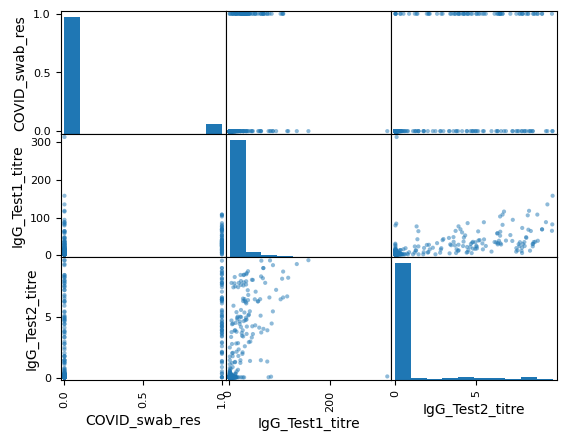

In [58]:
xx = pd.read_csv('covid_serological_results.csv')
# 0 -> negative, 1 -> uncertain, 2 -> positive.
# We want results with only 0 and 1
xx = xx[xx.COVID_swab_res != 1]  # so we remove uncertain results
xx.loc[xx.COVID_swab_res == 2, 'COVID_swab_res'] = 1 # and 2 is then replaced with 1
swab = xx.COVID_swab_res.values
Test1 = xx.IgG_Test1_titre.values
Test2 = xx.IgG_Test2_titre.values
pd.plotting.scatter_matrix(xx)

# Describe the data
description = xx.describe()
print(description)

# Exclude 'swab' from the matrix

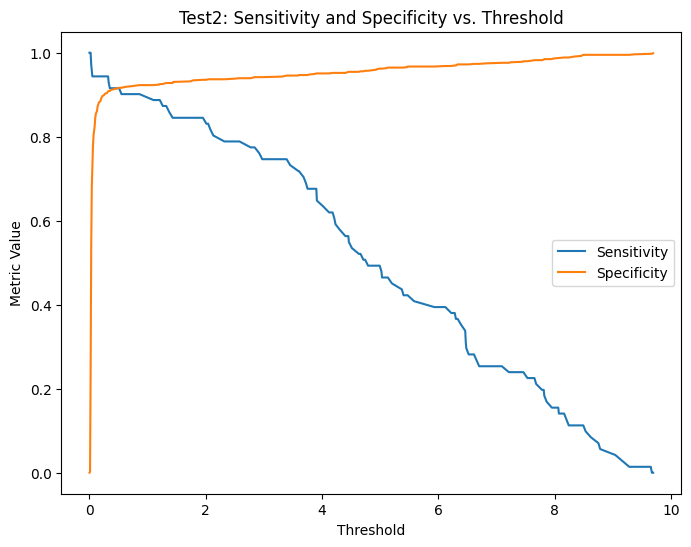

Best Threshold for Test2: 0.32
Sensitivity for Test2 with Best Threshold: 0.9436619718309859
Specificity for Test2 with Best Threshold: 0.9077117572692794


In [59]:
# Calcola sensitivity e specificity per Test2
thresholds_2, sensitivity_2, specificity_2 = calculate_sensitivity_specificity(Test2, swab)

# Plot sensitivity and specificity versus threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds_2, sensitivity_2, label='Sensitivity')
plt.plot(thresholds_2, specificity_2, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Test2: Sensitivity and Specificity vs. Threshold')
plt.legend()
plt.show()

# Converti le liste in array NumPy
sensitivity_2 = np.array(sensitivity_2)
specificity_2 = np.array(specificity_2)

# Trova la best threshold basandoti sulla somma di sensibilità e specificità
sum_metrics_Test2 = np.array(sensitivity_2) + np.array(specificity_2)
best_threshold_Test2 = thresholds_2[np.argmax(sum_metrics_Test2)]

# Stampa la best threshold
print("Best Threshold for Test2:", best_threshold_Test2)

# Calcola sensitivity e specificity per Test2 utilizzando la best threshold di Test2
thresholds_2, sensitivity_2, specificity_2 = calculate_sensitivity_specificity(Test2, swab, thresholds=[best_threshold_Test2])

# Estrai i valori di sensibilità e specificità per Test2
sensitivity_best_threshold_Test2 = sensitivity_2[0]
specificity_best_threshold_Test2 = specificity_2[0]

# Stampa i risultati
print("Sensitivity for Test2 with Best Threshold:", sensitivity_best_threshold_Test2)
print("Specificity for Test2 with Best Threshold:", specificity_best_threshold_Test2)

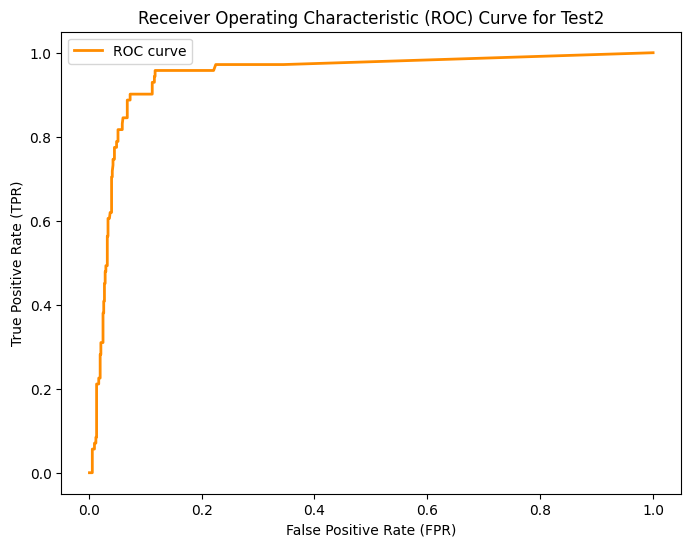

In [62]:
thresholds_2, sensitivity_2, specificity_2 = calculate_sensitivity_specificity(Test1, swab)
fpr_2 = 1 - np.array(specificity_2)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_2, sensitivity_2, color='darkorange', lw=2, label='ROC curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test2')
plt.legend()
plt.show()


In [63]:
# Calcolo della curva ROC per Test2
auc_test2_sklearn = metrics.roc_auc_score(swab, Test2)
print("AUC for Test2 (Scikit-Learn):", auc_test2_sklearn)


# Calcola l'AUC per Test2
auc_test2 = calculate_auc(fpr_2, sensitivity_2)
print("AUC for Test2:", auc_test2)


print(f'Error on roc_auc: roc_auc - true_roc_auc = { auc_test2 - auc_test2_sklearn}')

AUC for Test2 (Scikit-Learn): 0.9362546963195099
AUC for Test2: 0.9435284272003707
Error on roc_auc: roc_auc - true_roc_auc = 0.007273730880860807


In [65]:
# Calcola ROC curve per Test2
fpr_2, sensitivity_2, thresholds_2 = roc_curve(swab, Test2)

# Trova la soglia per ottenere sensibilità e specificità uguali
equal_sensitivity_specificity_threshold = thresholds_2[np.argmin(np.abs(sensitivity_2 - (1 - fpr_2)))]

# Stampa la soglia
print("Threshold for Equal Sensitivity and Specificity (Test2):", equal_sensitivity_specificity_threshold)

# Calcolo di sensitivity e specificity per la soglia di uguaglianza
true_positives_equal = np.sum((Test2 >= equal_sensitivity_specificity_threshold) & (swab == 1))
false_negatives_equal = np.sum((Test2 < equal_sensitivity_specificity_threshold) & (swab == 1))
true_negatives_equal = np.sum((Test2 < equal_sensitivity_specificity_threshold) & (swab == 0))
false_positives_equal = np.sum((Test2 >= equal_sensitivity_specificity_threshold) & (swab == 0))

sensitivity_equal = true_positives_equal / (true_positives_equal + false_negatives_equal)
specificity_equal = true_negatives_equal / (true_negatives_equal + false_positives_equal)

print("Specificity for Equal Sensitivity and Specificity Threshold (Test2):", specificity_equal)
print("Sensitivity for Equal Sensitivity and Specificity Threshold (Test2):", sensitivity_equal)



Threshold for Equal Sensitivity and Specificity (Test2): 0.51
Specificity for Equal Sensitivity and Specificity Threshold (Test2): 0.9165613147914032
Sensitivity for Equal Sensitivity and Specificity Threshold (Test2): 0.9154929577464789
Point on ROC Curve for Equal Sensitivity and Specificity Threshold (Test2): (0.08343868520859676, 0.9154929577464789)


Point on ROC Curve for Equal Sensitivity and Specificity Threshold (Test2): (0.08343868520859676, 0.9154929577464789)


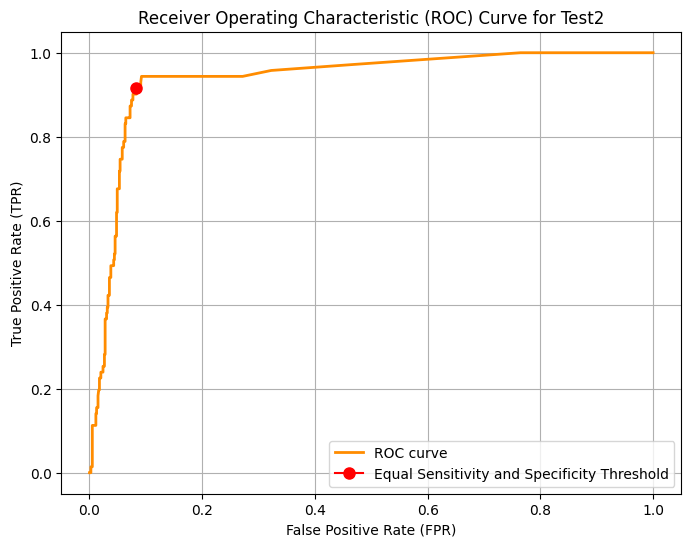

In [66]:
# Trova il punto sulla curva ROC corrispondente alla soglia di uguaglianza
point_on_roc_curve = (1 - specificity_equal, sensitivity_equal)

# Stampa le coordinate del punto sulla curva ROC
print("Point on ROC Curve for Equal Sensitivity and Specificity Threshold (Test2):", point_on_roc_curve)


# Plot ROC curve per Test2
plt.figure(figsize=(8, 6))
plt.plot(fpr_2, sensitivity_2, color='darkorange', lw=2, label='ROC curve')
plt.plot(point_on_roc_curve[0], point_on_roc_curve[1], marker='o', markersize=8, color="red", label='Equal Sensitivity and Specificity Threshold')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test2')
plt.legend()
plt.grid(True)
plt.show()